C:\Users\short\miniforge3\envs\WaveMAP\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


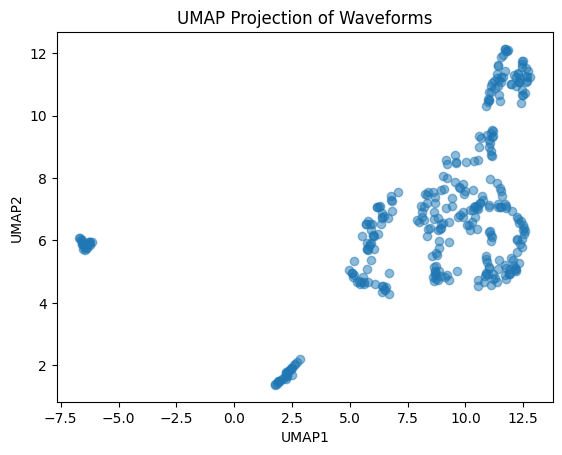

In [1]:
import os
import pandas as pd
import numpy as np
import concurrent.futures
from phylib.io.model import load_model
from umap import UMAP
from sklearn.preprocessing import normalize
from matplotlib import pyplot as plt

# Constants
BASE_DIR = r'D:\pc_lab\RCE\finished_proc\phy_curation'
RAND_STATE = 42
SAVE_PATH = r'D:\pc_lab\RCE\waveform_data.npy'  # Path to save the waveform data

def process_folder(folder):
    cluster_info_path = os.path.join(folder, 'phy', 'cluster_info.tsv')
    params_path = os.path.join(folder, 'phy', 'params.py')
    
    # Read the TSV file
    try:
        cluster_info = pd.read_csv(cluster_info_path, sep='\t')
    except Exception as e:
        print(f"Error reading {cluster_info_path}: {e}")
        return []

    try:
        good_clusters = np.intersect1d(
            cluster_info['cluster_id'][cluster_info['group'] == 'good'],
            cluster_info['cluster_id'][cluster_info['fr'] > 0.5]
        )
        
        # Load the TemplateModel
        model = load_model(params_path)
        
        # Initialize a list to store the mean waveforms and cluster IDs
        mean_waveforms = []
        cluster_ids = []
        
        for cluster_id in good_clusters:
            # Get cluster spike waveforms
            waveforms = model.get_cluster_spike_waveforms(cluster_id)[:, :, 0]
            # Calculate the mean waveform and normalize it
            mean_waveform = waveforms.mean(axis=0)
            norm_mean_waveform = normalize(mean_waveform.reshape(1, -1), norm='max').squeeze()
            mean_waveforms.append(norm_mean_waveform)
            cluster_ids.append(cluster_id)
        
        return list(zip(mean_waveforms, cluster_ids))
    
    except Exception as e:
        print(f"Error processing data in {folder}: {e}")
        return []

def main():
    # Retrieve all recording folders
    folders = [os.path.join(BASE_DIR, f) for f in os.listdir(BASE_DIR) if os.path.isdir(os.path.join(BASE_DIR, f))]
    
    # Process each folder
    results = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
        for result in executor.map(process_folder, folders):
            if result:
                results.extend(result)

    # Combine all waveforms and cluster IDs into a single list
    if not results:
        print("No waveforms found.")
        return

    normWFs_array = np.array([r[0] for r in results])
    cluster_ids = np.array([r[1] for r in results])

    # Save the results to a file
    np.save(SAVE_PATH, {'waveforms': normWFs_array, 'cluster_ids': cluster_ids})

    # Perform UMAP
    reducer = UMAP(random_state=RAND_STATE, n_neighbors=15)
    embedding = reducer.fit_transform(normWFs_array)

    # Plotting
    plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.5)
    plt.title('UMAP Projection of Waveforms')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.show()

if __name__ == "__main__":
    main()


In [2]:
# Load the saved data
SAVED_PATH = r"C:\Users\short\Documents\waveform_id\waveform_data.npy"  # Path to save the waveform data
data = np.load(SAVED_PATH, allow_pickle=True).item()
waveforms = data['waveforms']
cluster_ids = data['cluster_ids']

# Perform additional analyses on the waveforms and cluster IDs
# For example, print the first few entries
print("First few waveforms:", waveforms[:5])
print("First few cluster IDs:", cluster_ids[:5])

First few waveforms: [[ 1.09900601e-01  1.16567135e-01  1.24403417e-01  1.34262100e-01
   1.42375305e-01  1.46983489e-01  1.53452829e-01  1.61037937e-01
   1.63506851e-01  1.68747291e-01  1.79847777e-01  1.78168491e-01
   1.72374591e-01  1.87303007e-01  1.86558008e-01  1.56438470e-01
   1.72172874e-01  1.53616294e-01 -1.56399831e-01 -6.90808952e-01
  -1.00000000e+00 -9.14342582e-01 -7.10649014e-01 -5.71448743e-01
  -4.35301721e-01 -2.92782545e-01 -1.99703202e-01 -1.35554060e-01
  -6.78757057e-02 -1.31274695e-02  2.46012378e-02  6.35380819e-02
   1.05774872e-01  1.45173430e-01  1.80873662e-01  2.08247289e-01
   2.22965807e-01  2.28344783e-01  2.27325544e-01  2.19833732e-01]
 [ 6.82197958e-02  7.28436857e-02  7.73948133e-02  8.31204206e-02
   8.79654586e-02  8.95113349e-02  9.29927528e-02  9.85802561e-02
   9.71762314e-02  9.71702933e-02  1.07372269e-01  1.02769673e-01
   8.71899426e-02  1.04717985e-01  1.15111813e-01  7.20212683e-02
   8.86914581e-02  1.41294599e-01 -1.15646385e-01 -6.9

In [9]:
from umap import umap_ as umap

reducer = umap.UMAP(random_state = RAND_STATE, n_neighbors = 15)

mapper = reducer.fit(waveforms)

In [10]:
import networkx as nx

G = nx.from_scipy_sparse_array(mapper.graph_)

In [11]:
import cylouvain

clustering = cylouvain.best_partition(G, resolution = 2)

clustering_solution = list(clustering.values())

C:\Users\short\miniforge3\envs\WaveMAP\lib\site-packages\networkx\linalg\graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)


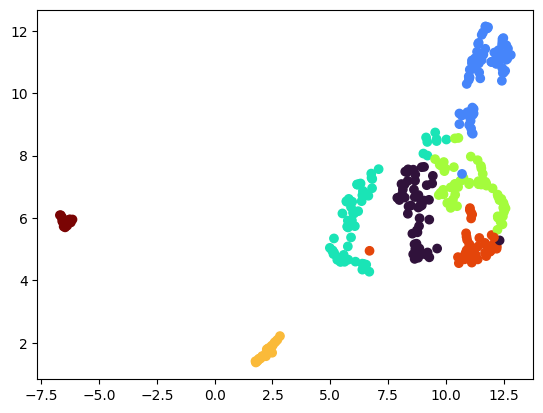

In [12]:
from matplotlib import cm

from matplotlib import pyplot as plt

embedding = reducer.fit_transform(waveforms)

umap_df = pd.DataFrame(embedding, columns=('x', 'y'))

umap_df['waveform'] = list(waveforms)

umap_df['cluster_id'] = clustering_solution

cmap = plt.get_cmap("turbo")

colors = cmap(np.linspace(0, 1, len(set(clustering_solution))))

umap_df['cluster_color'] = [colors[i] for i in clustering_solution]

plt.scatter(umap_df['x'].tolist(), umap_df['y'].tolist(),

marker='o', c=umap_df['cluster_id'].tolist(), cmap='turbo')

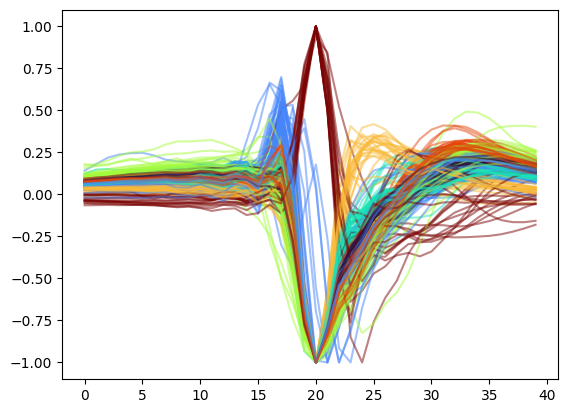

In [13]:
f,arr = plt.subplots(1)

for i,row in enumerate(umap_df['waveform'].tolist()):
    arr.plot(umap_df['waveform'].tolist()[i],c=umap_df['cluster_color'].tolist()[i],alpha=0.5)

In [15]:
umap_df.to_csv('umap_df.csv')

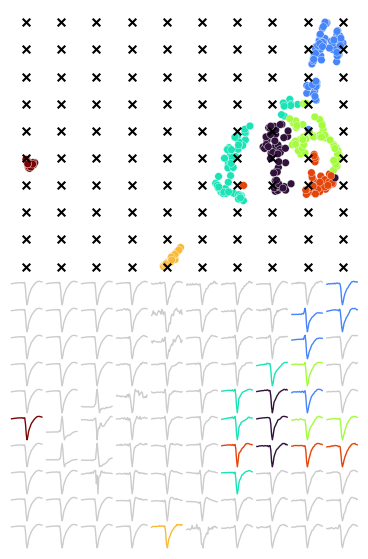

In [16]:
from wavemap_paper.helper_functions import plot_inverse_mapping

plot_inverse_mapping(reducer, umap_df)

In [17]:
from wavemap_paper.helper_functions import train_gridsearch_classifier

umap_model, conf_mat = train_gridsearch_classifier(umap_df)

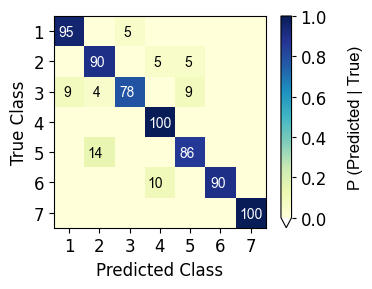

In [18]:
from wavemap_paper.helper_functions import plot_confusion_matrix

plot_confusion_matrix(conf_mat,umap_df)

In [19]:
import shap

import xgboost as xgb

xgbModel = xgb.XGBClassifier(umap_model.best_params_)

xgbModel.fit(umap_df['waveform'].tolist(),umap_df['cluster_id'].tolist())

explainer = shap.TreeExplainer(xgbModel)

Pass `objective` as keyword args.


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


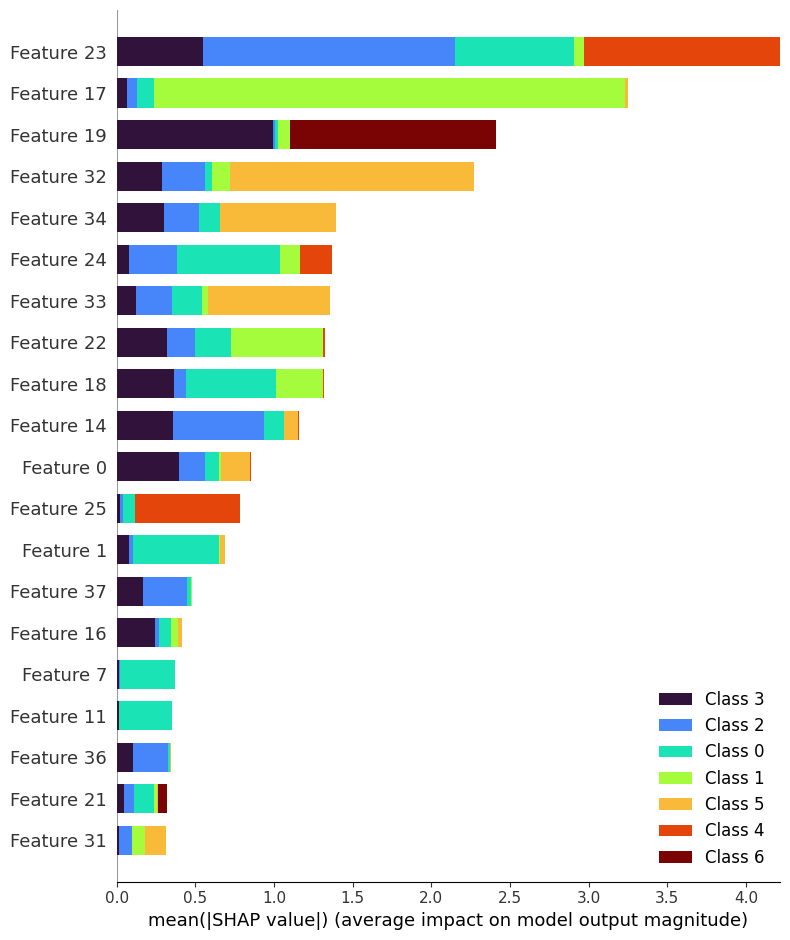

In [20]:
import matplotlib as mpl

umap_cmap = mpl.colors.ListedColormap(colors, name='umap_cmap')

shap_values = explainer.shap_values(umap_df['waveform'].tolist())

shap.summary_plot(shap_values, color = umap_cmap)